In [2]:
import numpy as np 
from matplotlib import pyplot as plt 
from numpy import random as rnd 
import seaborn as sns

## Start by just simulating some place cell data

- Per map, assign cell to have place field w/ x% probability 
    - Start w/ uniform, then allow for reward overreprepresentation
- Poisson or negative binomial noise
- Assuming a fixed, abrupt transition between maps 
- Then use HMM model of hippocampus, w/ remapping fraction correlated w/ probability of being in either map 
    - can just do some kind of unsupervised inference problem? like gaussian hmm 

On trial $i$ for neuron $k$

$$r_{ik} = I_{ik} * \phi_{kZ_{i}}(X_{i}) $$

$$Y_{ik} = Poi(r_{ik}) $$

Where $r =$ firing rate, $I = $ indicator of tuning to context and firing on trial, $\phi = $ neural tuning, $Z = $ context, $X = $ position, $Y = $ observed firing rate,

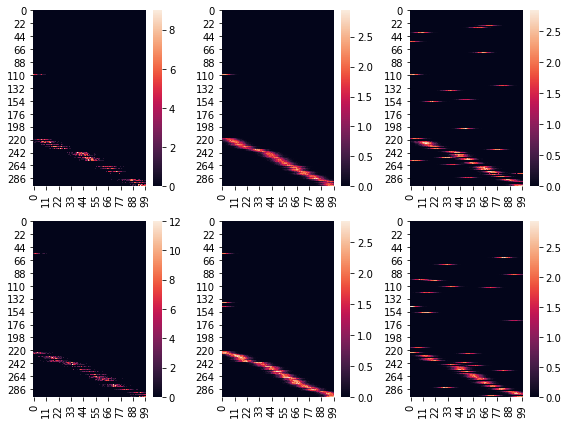

In [78]:
# parameters
n_trials = 120 
switch_trial = 70
n_posBins = 100 
n_neurons = 300
tau = .05
gain = 5
p_tuned = 0.3 # probability of having a place field in a context
p_fire = 0.4 # probability of place field firing on a trial 
p_remap = 0.3 # probability of remapping 

# define tuning function 
phi = {}
phi[0] = rnd.rand(n_neurons) * n_posBins 
phi[1] = rnd.rand(n_neurons) * n_posBins
unremapped = rnd.rand(n_neurons) > p_remap
phi[1][unremapped] = phi[0][unremapped] # neurons with common tuning 
I = {}
I[0] = (rnd.rand(n_neurons) < p_tuned).astype(int) # more likely to be non-uniform
I[1] = (rnd.rand(n_neurons) < p_tuned).astype(int)
I[1][unremapped] = I[0][unremapped] # neurons with common tuning 
I_fire = (rnd.rand(n_trials,n_neurons) < p_fire).astype(int)

# define context
Z = np.concatenate((np.zeros(switch_trial),np.ones(n_trials - switch_trial)))

# define weights per trial 
phi_z = np.concatenate([phi[z][np.newaxis,:] for z in Z])

# define stimulus - just sweeping over positions
X = np.linspace(0,n_posBins,n_posBins)
                
# Make firing rate and add noise
r = gain * np.exp(-0.5 * tau * ( np.tile(X[:,np.newaxis],(n_trials,1,n_neurons)) - np.tile(phi_z[:,np.newaxis,:],(1,n_posBins,1)))**2 )
r[Z == 0,:,:] = r[Z == 0,:,:] * I[0] 
r[Z == 1,:,:] = r[Z == 1,:,:] * I[1] 
r = (r.swapaxes(0,1) * I_fire).swapaxes(0,1)
y = rnd.poisson(r) 

# get peaksort for visualization 
peaks0 = np.argmax(y[Z == 0,:,:].mean(axis = 0),axis = 0)
peaksort0 = np.argsort(peaks0)
peaks1 = np.argmax(y[Z == 1,:,:].mean(axis = 0),axis = 0)
peaksort1 = np.argsort(peaks1)

# visualize w/ peaksort
fig , ax = plt.subplots(2,3,figsize = (8,6))
sns.heatmap(y[0,:,peaksort0].squeeze(),ax = ax[0,0])
sns.heatmap(y[Z == 0,:,:].mean(axis = 0)[:,peaksort0].T,ax = ax[0,1])
sns.heatmap(y[Z == 1,:,:].mean(axis = 0)[:,peaksort0].T,ax = ax[0,2])
sns.heatmap(y[switch_trial,:,peaksort1].squeeze(),ax = ax[1,0])
sns.heatmap(y[Z == 1,:,:].mean(axis = 0)[:,peaksort1].T,ax = ax[1,1])
sns.heatmap(y[Z == 0,:,:].mean(axis = 0)[:,peaksort1].T,ax = ax[1,2])
fig.tight_layout()


## Let's see what the kmeans approach does

In [31]:
from sklearn.cluster import KMeans

In [32]:
# first look at network similarity
corr = np.zeros((n_trials,n_trials))
for i_trial in range(n_trials): 
    for j_trial in range(n_trials): 
        corr[i_trial,j_trial] = np.corrcoef(y[i_trial,:,:].flatten(),y[j_trial,:,:].flatten())[0,1]

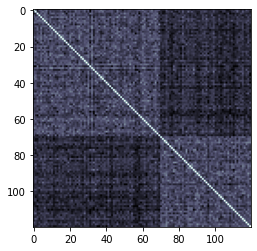

In [33]:
# network similarity 
plt.imshow(corr,cmap = 'bone')

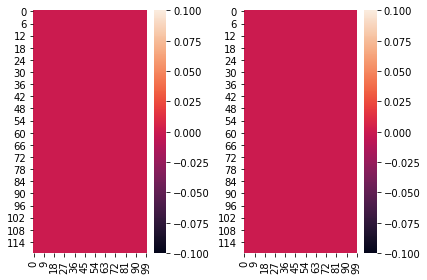

In [35]:
# fit kmeans
model = KMeans(2)
context_hat = model.fit_predict(y.reshape(n_trials,n_posBins * n_neurons))
y_hat = np.concatenate([model.cluster_centers_.reshape(2,n_posBins,n_neurons)[z,:,:][np.newaxis,:,:] for z in context_hat])

# visualize dimensionality reduction 
k_neuron = 78
fig, ax = plt.subplots(1,2)
sns.heatmap(y[:,:,k_neuron],ax = ax[0])
sns.heatmap(y_hat[:,:,k_neuron],ax = ax[1])
fig.tight_layout()


In [66]:
from sklearn.metrics import confusion_matrix 
plt.imshow(confusion_matrix(Z,context_hat))

ValueError: Found input variables with inconsistent numbers of samples: [120, 480]

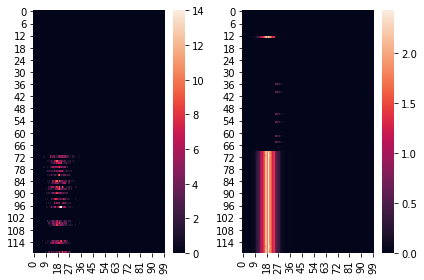

In [81]:
## Alternatively: try to divide into finer clustering to get within trial estimate of remapping timing
n_trackPhases = 4
trackPhase_edges = np.concatenate((np.arange(n_posBins, n_trackPhases,n_posBins / n_trackPhases),[n_posBins]))
trackPhase_masks = [(np.arange(n_posBins) > phaseStart) & (np.arange(n_posBins) > phaseEnd) for phaseStart,phaseEnd in zip(trackPhase_edges[:-1],trackPhase_edges[1:])]

model = KMeans(2 * n_trackPhases)
context_hat = model.fit_predict(y.reshape(n_trials * n_trackPhases,int(n_posBins * n_neurons / n_trackPhases)))

# reconstruct 
cluster_centers_reshape = model.cluster_centers_.reshape(2 * n_trackPhases , int(n_posBins / n_trackPhases),n_neurons)
context_hat_reshape = context_hat.reshape(n_trials,n_trackPhases)
y_hat = np.concatenate([np.concatenate([cluster_centers_reshape[z_i,:,:][np.newaxis,:,:] for z_i in context_hat_reshape[i_trial,:]],axis = 1) for i_trial in range(n_trials)])

# visualize dimensionality reduction 
remap_neurons = np.where((unremapped == 0) & ((I[0] > 0) | (I[1] > 0)))[0]
k_neuron = remap_neurons[0]
fig, ax = plt.subplots(1,2)
sns.heatmap(y[:,:,k_neuron],ax = ax[0])
sns.heatmap(y_hat[:,:,k_neuron],ax = ax[1])
fig.tight_layout()

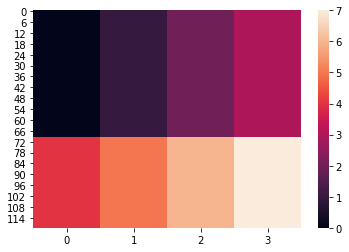

In [94]:
sns.heatmap(z_phases)
sns.heatmap()

0.9520833333333333


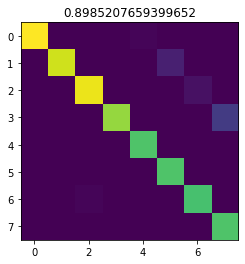

In [117]:
from scipy.stats import mode 
from sklearn.metrics import adjusted_rand_score,accuracy_score

# put true contexts in an easier format to deal with 
z_phases = np.concatenate((np.tile(np.arange(n_trackPhases),(switch_trial,1)),np.tile(np.arange(n_trackPhases,2 * n_trackPhases),(n_trials - switch_trial,1)))) # .flatten()

# adjust for random ordering of clusters 
reordering_mapper = {z : mode(z_phases.flatten()[context_hat == z])[0][0] for z in range(2 * n_trackPhases)}
context_hat_adj = np.array([reordering_mapper[z_hat] for z_hat in context_hat])

# show confusion mat 
plt.imshow(confusion_matrix(z_phases.flatten(),context_hat_adj)) # ok, so we get a bit worse
plt.title(adjusted_rand_score(z_phases.flatten(),context_hat_adj))
print(accuracy_score(z_phases.flatten(),context_hat_adj))

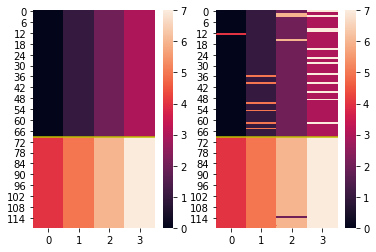

In [112]:
fig,ax = plt.subplots(1,2)
sns.heatmap(z_phases.reshape(n_trials, 4),ax = ax[0])
ax[0].hlines(switch_trial,0,n_trackPhases,color = 'y')
sns.heatmap(context_hat_adj.reshape(n_trials, 4),ax = ax[1])
ax[1].hlines(switch_trial,0,n_trackPhases,color = 'y')

## Ok, let's look at what happens when we make remapping dependent on something like dirichlet process / HMM inference